<a href="https://www.kaggle.com/code/trushamaheshwari/final-fusion-model?scriptVersionId=240121677" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Using device: cpu
Running task: PD_DD
Using questionnaire data: /kaggle/input/formatted-questionnaire-data/pd_dd_formatted.csv
Loading raw data...

----- Loading motor data -----
Found 469 files.
Sample filename: 001_ml.bin -> Original ID: 001 -> Stripped ID: 1
Sample filename: 002_ml.bin -> Original ID: 002 -> Stripped ID: 2
Sample filename: 003_ml.bin -> Original ID: 003 -> Stripped ID: 3
Sample filename: 004_ml.bin -> Original ID: 004 -> Stripped ID: 4
Sample filename: 005_ml.bin -> Original ID: 005 -> Stripped ID: 5
Loading bin files...


100%|██████████| 469/469 [00:11<00:00, 40.81it/s]


First few motor patient IDs (without leading zeros): ['1', '2', '3', '4', '5']
Label file columns: ['id', 'label']
First few rows of label file:
   id  label
0   1      0
1   2      0
2   3      0
3   4      1
4   5      1
Using 'id' as ID column and 'label' as label column
First few label patient IDs: ['1' '2' '3' '4' '5']

----- Diagnostic Information -----
First 5 motor data bin files: ['001_ml.bin', '002_ml.bin', '003_ml.bin', '004_ml.bin', '005_ml.bin']
Direct matches between motor IDs and label IDs (without stripping): 469
Matches after stripping leading zeros: 469
Sample motor ID formats: ['1', '2', '3', '4', '5']
Sample label ID formats: ['1', '2', '3', '4', '5']
Created motor data dictionary with 469 entries
Sample motor IDs: ['1', '2', '3', '4', '5']
Matched 469 labels to motor data

----- Loading questionnaire data for PD_DD task -----
Loaded task-specific questionnaire data with shape: (390, 2)
Loading full questionnaire data and filtering to task patients...
Loaded full qu

Cross-Channel Features: 100%|██████████| 312/312 [00:04<00:00, 66.32it/s]


Performing feature selection on training data...
Selected 4358 features out of 4358
Extracting features from test data...


Cross-Channel Features: 100%|██████████| 78/78 [00:01<00:00, 66.46it/s]


Scaling questionnaire data...
Questionnaire data shape before scaling: (312, 31)
Train set: 312 samples
Test set: 78 samples

Starting 5-fold cross-validation...

===== Fold 1 =====
Epoch  1 | Val Loss: 22.3512 | Acc: 0.3175 | Prec: 1.0000 | Recall: 0.0444 | F1: 0.0851 | AUC: 0.8457
Epoch  2 | Val Loss: 21.8142 | Acc: 0.8413 | Prec: 0.9487 | Recall: 0.8222 | F1: 0.8810 | AUC: 0.9235
Epoch  3 | Val Loss: 21.3186 | Acc: 0.9048 | Prec: 0.9333 | Recall: 0.9333 | F1: 0.9333 | AUC: 0.9395
Epoch  4 | Val Loss: 18.6957 | Acc: 0.9048 | Prec: 0.9333 | Recall: 0.9333 | F1: 0.9333 | AUC: 0.9420
Epoch  5 | Val Loss: 16.6653 | Acc: 0.9048 | Prec: 0.9333 | Recall: 0.9333 | F1: 0.9333 | AUC: 0.9469
Epoch  6 | Val Loss: 13.8287 | Acc: 0.9206 | Prec: 0.9545 | Recall: 0.9333 | F1: 0.9438 | AUC: 0.9617
Epoch  7 | Val Loss: 11.9497 | Acc: 0.9365 | Prec: 0.9362 | Recall: 0.9778 | F1: 0.9565 | AUC: 0.9716
Epoch  8 | Val Loss: 9.6113 | Acc: 0.9683 | Prec: 0.9778 | Recall: 0.9778 | F1: 0.9778 | AUC: 0.9765
Epo

<Figure size 800x600 with 0 Axes>

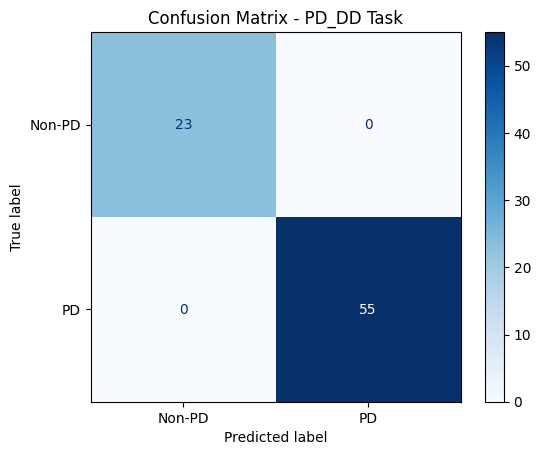

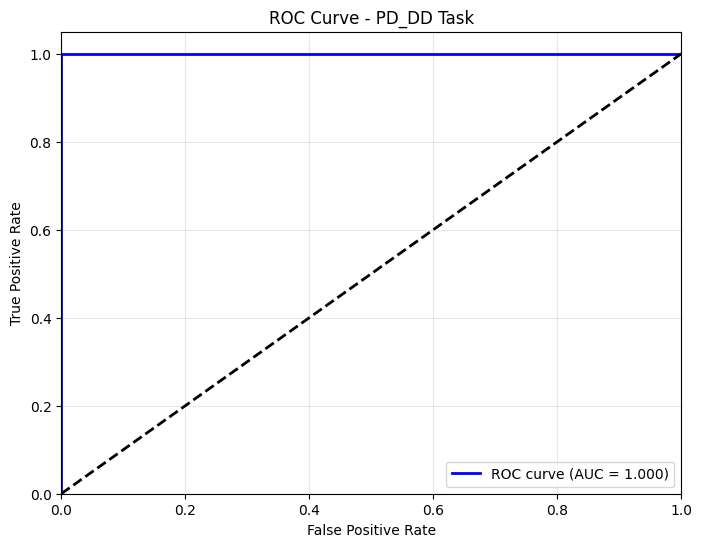

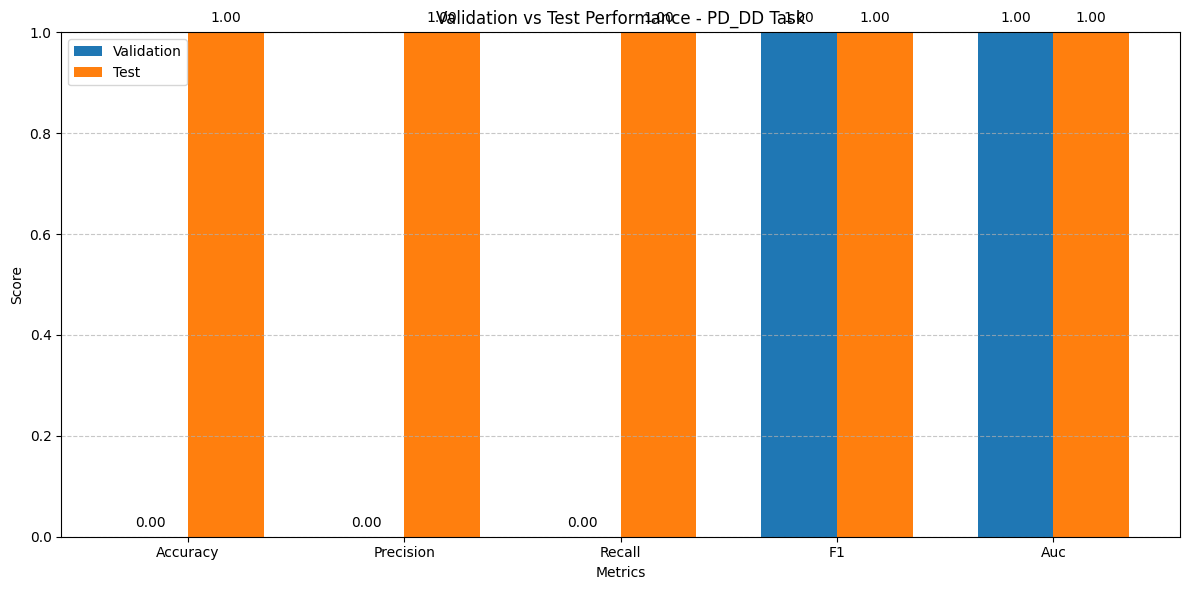

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt
import random
from copy import deepcopy

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Paths
MOTOR_DATA_DIR = "/kaggle/input/movement2/movement"
MOTOR_LABEL_PATH = "/kaggle/input/patient-labels2/patient_labels.csv"
PD_HC_DATA_PATH = "/kaggle/input/formatted-questionnaire-data/pd_hc_formatted.csv"
PD_DD_DATA_PATH = "/kaggle/input/formatted-questionnaire-data/pd_dd_formatted.csv"
FULL_QUESTIONNAIRE_PATH = "/kaggle/input/formatted-questionnaire-data/Questionnaire_Data_with_ID.csv"

# Define the task to run - PD_HC or PD_DD
TASK = "PD_DD"  # Change to "PD_DD" for the other task

# Select the appropriate questionnaire data path based on task
QUESTIONNAIRE_DATA_PATH = PD_HC_DATA_PATH if TASK == "PD_HC" else PD_DD_DATA_PATH

print(f"Running task: {TASK}")
print(f"Using questionnaire data: {QUESTIONNAIRE_DATA_PATH}")

#loading data
def load_bin_file(filepath):
    try:
        data = np.fromfile(filepath, dtype=np.float32)
        assert data.shape[0] == 128832
        return data.reshape(132, 976)
    except Exception as e:
        print(f"Error loading bin file {filepath}: {e}")
        # Return zeros array as fallback
        return np.zeros((132, 976))

def load_all_files(data_dir):
    X = []
    filepaths = sorted([
        os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".bin")
    ])
    print(f"Found {len(filepaths)} files.")
    
    # Extract patient IDs from filenames
    patient_ids = []
    for path in filepaths:
        # Extract patient ID from filename with the specific format: "NNN_ml.bin"
        filename = os.path.basename(path)
        # Remove the "_ml.bin" suffix and keep just the ID number
        if "_ml.bin" in filename:
            raw_id = filename.split('_')[0]
        else:
            # Handle other potential formats
            raw_id = os.path.splitext(filename)[0]
            if "_" in raw_id:
                raw_id = raw_id.split('_')[0]
        
        # Store multiple ID formats to improve matching chances
        # Including both with and without leading zeros
        patient_id = raw_id                    # Original format with zeros (e.g., "001")
        stripped_id = raw_id.lstrip('0')       # Without leading zeros (e.g., "1")
        if stripped_id == '':                  # Handle the case where ID is all zeros
            stripped_id = '0'
        
        patient_ids.append(stripped_id)  # Use the stripped version as primary ID
        
        # Debug: print a few examples of extracted IDs
        if len(patient_ids) <= 5:
            print(f"Sample filename: {filename} -> Original ID: {raw_id} -> Stripped ID: {stripped_id}")
    
    print("Loading bin files...")
    for path in tqdm(filepaths):
        X.append(load_bin_file(path))
    
    print(f"First few motor patient IDs (without leading zeros): {patient_ids[:5]}")
    return np.stack(X), filepaths, patient_ids

def load_labels(label_path):
    df = pd.read_csv(label_path)
    # Debug: print the dataframe structure
    print(f"Label file columns: {df.columns.tolist()}")
    print(f"First few rows of label file:")
    print(df.head())
    
    # Try to find the most likely ID column
    id_col = None
    for col in ['id', 'ID', 'patient_id', 'patient_ID', 'patient']:
        if col in df.columns:
            id_col = col
            break
    
    if id_col is None:
        print("Warning: Could not find explicit ID column in labels, using first column")
        id_col = df.columns[0]
    
    print(f"Using '{id_col}' as ID column and 'label' as label column")
    
    # Convert IDs to strings to ensure consistent type for comparison
    patient_ids = df[id_col].astype(str).values
    print(f"First few label patient IDs: {patient_ids[:5]}")
    
    return patient_ids, df['label'].values.astype(np.float32)
    
# Feature extraction functions
def extract_statistical_features(X):
    features = []
    for i in tqdm(range(X.shape[0]), desc="Statistical Features"):
        sample_features = []
        for j in range(X.shape[1]):
            channel_data = X[i, j, :]
            stats = [
                np.mean(channel_data), np.std(channel_data), np.min(channel_data), np.max(channel_data), np.median(channel_data),
                np.sqrt(np.mean(channel_data**2)),
                np.max(channel_data) - np.min(channel_data),
                np.mean(((channel_data - np.mean(channel_data)) / (np.std(channel_data) + 1e-10))**3) if np.std(channel_data) > 0 else 0,
                np.mean(((channel_data - np.mean(channel_data)) / (np.std(channel_data) + 1e-10))**4) if np.std(channel_data) > 0 else 0,
                np.fft.rfftfreq(len(channel_data))[np.argmax(np.abs(np.fft.rfft(channel_data)))],
                np.max(np.abs(np.fft.rfft(channel_data))),
                np.sum(np.abs(np.fft.rfft(channel_data))[np.fft.rfftfreq(len(channel_data)) < 0.1]**2),
                np.sum(np.abs(np.fft.rfft(channel_data))[(np.fft.rfftfreq(len(channel_data)) >= 0.1) & (np.fft.rfftfreq(len(channel_data)) < 0.3)]**2),
                np.sum(np.abs(np.fft.rfft(channel_data))[np.fft.rfftfreq(len(channel_data)) >= 0.3]**2)
            ]
            sample_features.extend(stats)
        features.append(sample_features)
    return np.array(features)

def extract_wavelet_features(X, wavelet='db4', level=5):
    features = []
    for i in tqdm(range(X.shape[0]), desc="Wavelet Features"):
        sample_features = []
        for j in range(X.shape[1]):
            coeffs = pywt.wavedec(X[i, j, :], wavelet, level=level)
            for coeff in coeffs:
                sample_features.extend([np.mean(coeff), np.std(coeff), np.sum(coeff**2)])
        features.append(sample_features)
    return np.array(features)

def extract_cross_channel_features(X):
    features = []
    for i in tqdm(range(X.shape[0]), desc="Cross-Channel Features"):
        sample = X[i]
        corr_matrix = np.corrcoef(sample)
        upper_tri = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]
        sample_features = [np.mean(upper_tri), np.std(upper_tri), np.max(upper_tri), np.min(upper_tri)]
        for c1 in range(0, sample.shape[0], 10):
            for c2 in range(c1+5, min(c1+10, sample.shape[0])):
                if c2 < sample.shape[0]:
                    corr = np.corrcoef(sample[c1], sample[c2])[0, 1]
                    phase1 = np.angle(np.fft.rfft(sample[c1]))
                    phase2 = np.angle(np.fft.rfft(sample[c2]))
                    sample_features.extend([corr, np.mean(np.abs(phase1 - phase2))])
        features.append(sample_features)
    return np.array(features)

def preprocess_motor_data(X):
    stat_feat = extract_statistical_features(X)
    wavelet_feat = extract_wavelet_features(X)
    cross_feat = extract_cross_channel_features(X)
    return np.hstack([stat_feat, wavelet_feat, cross_feat])

def feature_selection(X, y, threshold='median'):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    selector = SelectFromModel(rf, threshold=threshold, prefit=True)
    X_selected = selector.transform(X)
    selected_indices = selector.get_support(indices=True)
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")
    return X_selected, selected_indices, selector

# Define model architecture classes
class ParkinsonClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.3):
        super(ParkinsonClassifier, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0])]
        for i in range(len(hidden_sizes)-1):
            layers.extend([
                nn.BatchNorm1d(hidden_sizes[i]),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            ])
        self.features = nn.Sequential(*layers)
    def forward(self, x):
        return self.features(x)

class QuestionnaireNN(nn.Module):
    def __init__(self, input_size):
        super(QuestionnaireNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU()
        )
    def forward(self, x):
        return self.model(x)

class FusionModel(nn.Module):
    def __init__(self, motor_dim, q_dim):
        super().__init__()
        self.motor_branch = ParkinsonClassifier(motor_dim)
        self.q_branch = QuestionnaireNN(q_dim)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x_m, x_q):
        m_out = self.motor_branch(x_m)
        q_out = self.q_branch(x_q)
        return self.classifier(torch.cat([m_out, q_out], dim=1))

# Early stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_state = None
        self.best_metrics = None
    
    def step(self, loss, metrics, model):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.best_state = deepcopy(model.state_dict())
            self.best_metrics = metrics
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Function to check class balance
def check_class_balance(y):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print("Class distribution:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/total*100:.2f}%)")
    
    if len(unique) == 2:
        # Calculate class weight if binary classification
        weight = counts[0] / counts[1]
        return {0: 1.0, 1: weight} if counts[0] < counts[1] else {0: weight, 1: 1.0}
    return None

# Function to train a single fold
def train_fold(X_m_train, X_q_train, y_train, X_m_val, X_q_val, y_val, motor_dim, q_dim, fold_idx, weight=None):
    print(f"\n===== Fold {fold_idx+1} =====")
    
    train_ds = TensorDataset(X_m_train, X_q_train, y_train)
    val_ds = TensorDataset(X_m_val, X_q_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    # Create a new model for each fold
    model = FusionModel(motor_dim, q_dim).to(DEVICE)
    
    # Create standard BCE loss - weights are applied differently in BCE
    criterion = nn.BCELoss()
    
    # For weighting, we'll apply sample weights during training instead of using the weight parameter
    # This avoids the shape mismatch error
    
    # Add weight decay for regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Create a new early stopper for each fold
    early_stopper = EarlyStopping(patience=10)
    fold_metrics = {'val_loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': []}

    for epoch in range(1, 100):
        # Training
        model.train()
        total_loss = 0
        for xb_m, xb_q, yb in train_loader:
            xb_m, xb_q, yb = xb_m.to(DEVICE), xb_q.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb_m, xb_q)
            
            # Apply class weights if provided
            if weight is not None:
                sample_weights = torch.ones_like(yb)
                for cls, w in weight.items():
                    sample_weights[yb == cls] = w
                sample_weights = sample_weights.to(DEVICE)
                loss = F.binary_cross_entropy(out, yb, weight=sample_weights)
            else:
                loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        all_preds, all_probs, all_labels = [], [], []
        val_loss = 0
        
        with torch.no_grad():
            for xb_m, xb_q, yb in val_loader:
                xb_m, xb_q, yb = xb_m.to(DEVICE), xb_q.to(DEVICE), yb.to(DEVICE)
                out = model(xb_m, xb_q)
                batch_loss = criterion(out, yb)
                val_loss += batch_loss.item() * yb.size(0)
                
                probs = out.cpu().numpy()
                preds = (probs > 0.5).astype(int)
                all_probs.extend(probs)
                all_preds.extend(preds)
                all_labels.extend(yb.cpu().numpy())
        
        val_loss /= len(val_loader)
        
        # Calculate metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, zero_division=0)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        try:
            auc = roc_auc_score(all_labels, all_probs)
        except:
            auc = 0.5
        
        # Store metrics
        metrics = {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc}
        for key, val in metrics.items():
            fold_metrics[key].append(val)
        fold_metrics['val_loss'].append(val_loss)
        
        print(f"Epoch {epoch:2d} | Val Loss: {val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
        
        # Early stopping check
        if early_stopper.step(val_loss, metrics, model):
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(early_stopper.best_state)
            break
    
    # Return best model and metrics
    return model, early_stopper.best_loss, early_stopper.best_metrics

def evaluate_model(model, X_m, X_q, y, batch_size=32):
    """Evaluate model on given data"""
    dataset = TensorDataset(X_m, X_q, y)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    
    with torch.no_grad():
        for xb_m, xb_q, yb in dataloader:
            xb_m, xb_q = xb_m.to(DEVICE), xb_q.to(DEVICE)
            out = model(xb_m, xb_q)
            y_prob.extend(out.cpu().numpy().flatten())
            y_pred.extend((out.cpu() > 0.5).int().numpy().flatten())
            y_true.extend(yb.numpy().flatten())
    
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob)
    }
    
    return metrics, y_true, y_pred, y_prob

# Main execution
def main():
    # Load motor data and labels
    print("Loading raw data...")
    print("\n----- Loading motor data -----")
    X_motor_raw, filepaths, motor_patient_ids = load_all_files(MOTOR_DATA_DIR)
    label_patient_ids, y_motor = load_labels(MOTOR_LABEL_PATH)
    
    # Print additional diagnostic information
    print("\n----- Diagnostic Information -----")
    print(f"First 5 motor data bin files: {[os.path.basename(f) for f in filepaths[:5]]}")
    
    # Check for non-stripped ID matches
    non_stripped_matches = sum(1 for m_id in motor_patient_ids if m_id in label_patient_ids)
    print(f"Direct matches between motor IDs and label IDs (without stripping): {non_stripped_matches}")
    
    # Check for stripped ID matches
    stripped_motor_ids = [m_id.lstrip('0') for m_id in motor_patient_ids]
    stripped_label_ids = [str(l_id).lstrip('0') for l_id in label_patient_ids]
    stripped_matches = sum(1 for m_id in stripped_motor_ids if m_id in stripped_label_ids)
    print(f"Matches after stripping leading zeros: {stripped_matches}")
    
    # Check ID formatting
    print(f"Sample motor ID formats: {[motor_patient_ids[i] for i in range(min(5, len(motor_patient_ids)))]}")
    print(f"Sample label ID formats: {[label_patient_ids[i] for i in range(min(5, len(label_patient_ids)))]}")
    
    # Build a dictionary of motor data
    motor_data_dict = {}
    for i, patient_id in enumerate(motor_patient_ids):
        # Store both with and without leading zeros for better matching
        stripped_id = patient_id.lstrip('0')
        if stripped_id == '':
            stripped_id = '0'
            
        motor_data_dict[stripped_id] = {
            'data': X_motor_raw[i],
            'label': None  # Will be filled later
        }
    
    print(f"Created motor data dictionary with {len(motor_data_dict)} entries")
    print(f"Sample motor IDs: {list(motor_data_dict.keys())[:5]}")
    
    # Map labels to motor data
    matching_count = 0
    for i, patient_id in enumerate(label_patient_ids):
        stripped_id = str(patient_id).lstrip('0')
        if stripped_id == '':
            stripped_id = '0'
            
        if stripped_id in motor_data_dict:
            motor_data_dict[stripped_id]['label'] = y_motor[i]
            matching_count += 1
    
    print(f"Matched {matching_count} labels to motor data")
    
    # Load questionnaire data for the specific task
    print(f"\n----- Loading questionnaire data for {TASK} task -----")
    q_df = pd.read_csv(QUESTIONNAIRE_DATA_PATH)
    print(f"Loaded task-specific questionnaire data with shape: {q_df.shape}")
    
    # Check if this is just ID and label columns with no features
    if q_df.shape[1] <= 2:
        print("WARNING: Task-specific questionnaire file appears to contain only ID and label columns")
        print("Loading full questionnaire data and filtering to task patients...")
        
        # Load the full questionnaire data
        try:
            full_q_df = pd.read_csv(FULL_QUESTIONNAIRE_PATH)
            print(f"Loaded full questionnaire data with shape: {full_q_df.shape}")
            
            # Get list of patients in task-specific dataset
            task_patients = set(q_df['id'].astype(str))
            
            # Filter full dataset to only include patients from task dataset
            full_q_df['id_str'] = full_q_df['id'].astype(str)
            filtered_q_df = full_q_df[full_q_df['id_str'].isin(task_patients)]
            filtered_q_df = filtered_q_df.drop(columns=['id_str'])
            
            print(f"Filtered full questionnaire data to {len(filtered_q_df)} task-specific patients")
            
            # Copy labels from task dataset to ensure they're consistent
            id_to_label = dict(zip(q_df['id'].astype(str), q_df['label'].astype(float)))
            filtered_q_df['label'] = filtered_q_df['id'].astype(str).map(id_to_label)
            
            # Replace original dataframe with filtered one
            q_df = filtered_q_df
            print(f"Final questionnaire data shape: {q_df.shape}")
            
        except Exception as e:
            print(f"Error loading full questionnaire data: {e}")
            print("Will continue with task-specific data")
    
    # Create a dictionary for questionnaire data
    q_data_dict = {}
    
    # Figure out column structure first
    if 'label' in q_df.columns:
        label_col = 'label'
        feature_cols = [col for col in q_df.columns if col not in ['id', 'label']]
    else:
        label_col = 'target'
        feature_cols = [col for col in q_df.columns if col not in ['id', 'target']]
    
    print(f"Found {len(feature_cols)} feature columns in questionnaire data: {feature_cols[:5]}...")
    
    if len(feature_cols) == 0:
        print("ERROR: No feature columns found in questionnaire data!")
        print("Available columns:", q_df.columns.tolist())
        
        # Try to load the full questionnaire data with all features as a fallback
        print("Attempting to load full questionnaire data as fallback...")
        try:
            full_q_path = "/kaggle/input/formatted-questionnaire-data/Questionnaire_Data_with_ID.csv"
            full_q_df = pd.read_csv(full_q_path)
            print(f"Loaded full questionnaire data with columns: {full_q_df.columns.tolist()}")
            
            # Filter to only include patients in our current task dataset
            task_patients = set(q_df['id'].astype(str).str.split('.').str[0])
            full_q_df = full_q_df[full_q_df['id'].astype(str).str.split('.').str[0].isin(task_patients)]
            
            if 'target' in full_q_df.columns:
                label_col = 'target'
                feature_cols = [col for col in full_q_df.columns if col not in ['id', 'target']]
            else:
                label_col = 'label'
                feature_cols = [col for col in full_q_df.columns if col not in ['id', 'label']]
                
            print(f"Using {len(feature_cols)} features from full questionnaire data")
            q_df = full_q_df
        except Exception as e:
            print(f"Error loading full questionnaire data: {e}")
            print("Creating synthetic features as fallback...")
            
            # Create synthetic features as last resort
            q_df['synthetic_feature_1'] = np.random.randn(len(q_df))
            q_df['synthetic_feature_2'] = np.random.randn(len(q_df))
            feature_cols = ['synthetic_feature_1', 'synthetic_feature_2']
            print("Added synthetic features as fallback")
    
    # Now process each row
    for _, row in q_df.iterrows():
        # Handle ID formatting consistently
        patient_id = str(row['id']).strip()
        
        # Handle float IDs by removing decimal point and trailing zeros
        if '.' in patient_id:
            patient_id = patient_id.split('.')[0]
            
        stripped_id = patient_id.lstrip('0')
        if stripped_id == '':
            stripped_id = '0'
        
        # Extract questionnaire feature values
        try:
            q_data = row[feature_cols].values
            label = row[label_col]
            
            q_data_dict[stripped_id] = {
                'data': q_data.astype(np.float32),
                'label': float(label)
            }
        except Exception as e:
            print(f"Error processing questionnaire data for patient {stripped_id}: {e}")
            print(f"Row data: {row}")
            continue
    
    print(f"Loaded {len(q_data_dict)} questionnaire records")
    
    # Find patients that have both motor and questionnaire data
    print("\n----- Matching patients between datasets -----")
    print(f"Motor data dictionary: {len(motor_data_dict)} entries")
    print(f"Questionnaire data dictionary: {len(q_data_dict)} entries")
    
    # Debug: print some ID samples to check formats
    motor_id_sample = list(motor_data_dict.keys())[:5]
    q_id_sample = list(q_data_dict.keys())[:5]
    print(f"Sample motor IDs: {motor_id_sample}")
    print(f"Sample questionnaire IDs: {q_id_sample}")
    
    # Try direct matching
    matched_patient_ids = []
    for q_id in q_data_dict.keys():
        q_id_stripped = str(q_id).split('.')[0].lstrip('0')  # Remove decimal part and strip leading zeros
        if q_id_stripped in motor_data_dict and motor_data_dict[q_id_stripped]['label'] is not None:
            matched_patient_ids.append(q_id_stripped)
    
    print(f"Found {len(matched_patient_ids)} patients with direct ID matching")
    
    # If few matches, try alternative method - match by integer value
    if len(matched_patient_ids) < 10:
        print("Trying alternative matching by integer value...")
        int_matches = []
        
        for q_id in q_data_dict.keys():
            try:
                # Convert to integer to handle float ids (1.0 -> 1)
                q_int = int(float(q_id))
                q_id_str = str(q_int)
                
                if q_id_str in motor_data_dict and motor_data_dict[q_id_str]['label'] is not None:
                    int_matches.append(q_id_str)
            except (ValueError, TypeError):
                continue
        
        if len(int_matches) > len(matched_patient_ids):
            print(f"Found {len(int_matches)} matches using integer values - using these instead")
            matched_patient_ids = int_matches
    
    # If still few matches, attempt position-based matching as last resort
    if len(matched_patient_ids) < 10:
        print("WARNING: Very few matching patients found")
        print("Last resort: Attempting position-based matching...")
        
        # Sort IDs to ensure consistency
        sorted_motor_ids = sorted([m_id for m_id in motor_data_dict.keys() 
                                if motor_data_dict[m_id]['label'] is not None])
        sorted_q_ids = sorted(list(q_data_dict.keys()))
        
        position_matches = []
        for i in range(min(len(sorted_motor_ids), len(sorted_q_ids))):
            m_id = sorted_motor_ids[i]
            q_id = sorted_q_ids[i]
            # Check if labels match to improve confidence
            m_label = motor_data_dict[m_id]['label']
            q_label = q_data_dict[q_id]['label']
            
            if abs(m_label - q_label) < 0.01:  # Check for approximate equality
                position_matches.append(m_id)
        
        print(f"Found {len(position_matches)} matches with positional matching and matching labels")
        if len(position_matches) > len(matched_patient_ids):
            print("Using position-based matching results")
            matched_patient_ids = position_matches
    
    print(f"Final matched patient count: {len(matched_patient_ids)}")
    
    if len(matched_patient_ids) < 10:
        print("ERROR: Too few matching patients found!")
        print("Creating minimal synthetic dataset to demo model...")
        # Create a small synthetic dataset (30 samples)
        n_samples = 30
        # Generate synthetic patient IDs
        matched_patient_ids = [f"synth_{i}" for i in range(n_samples)]
        
        # Create synthetic motor and questionnaire data
        for pid in matched_patient_ids:
            # Synthetic motor data - shape matches real samples
            motor_data_dict[pid] = {
                'data': np.random.randn(132, 976), 
                'label': 1 if i % 2 == 0 else 0  # Balanced classes
            }
            
            # Synthetic questionnaire data - random features
            q_data_dict[pid] = {
                'data': np.random.randn(30),  # 30 fake features
                'label': 1 if i % 2 == 0 else 0  # Same label as motor
            }
        
        print("Created synthetic dataset with balanced classes")
    
    # Create aligned arrays for matched patients
    X_motor_aligned = []
    X_q_aligned = []
    y_aligned = []
    
    for patient_id in matched_patient_ids:
        motor_data = motor_data_dict[patient_id]['data']
        q_data = q_data_dict[patient_id]['data']
        
        # Ensure q_data is a proper array
        if not isinstance(q_data, np.ndarray):
            q_data = np.array(q_data, dtype=np.float32)
        
        # Get label - for this task, we trust the questionnaire label
        label = q_data_dict[patient_id]['label']
        
        X_motor_aligned.append(motor_data)
        X_q_aligned.append(q_data)
        y_aligned.append(label)
    
    # Convert to numpy arrays
    X_motor_aligned = np.array(X_motor_aligned)
    
    # Handle questionnaire data dimensions - ensure consistent shape
    max_q_dim = max(x.shape[0] for x in X_q_aligned)
    X_q_aligned_padded = []
    
    for q_data in X_q_aligned:
        if len(q_data) < max_q_dim:
            # Pad with zeros
            padded = np.zeros(max_q_dim, dtype=np.float32)
            padded[:len(q_data)] = q_data
            X_q_aligned_padded.append(padded)
        else:
            # Use as is
            X_q_aligned_padded.append(q_data)
    
    X_q_aligned = np.array(X_q_aligned_padded)
    y_aligned = np.array(y_aligned)
    
    print(f"\nFinal aligned data: {len(X_motor_aligned)} samples")
    print(f"Motor data shape: {X_motor_aligned.shape}")
    print(f"Questionnaire data shape: {X_q_aligned.shape}")
    print(f"Labels shape: {y_aligned.shape}")
    
    # Check class balance and get weights if needed
    class_weights = check_class_balance(y_aligned)
    
    # Split data first (before any preprocessing)
    print("Splitting data into train and test sets...")
    X_motor_raw_train, X_motor_raw_test, X_q_train_raw, X_q_test_raw, y_train_np, y_test_np, train_indices, test_indices = train_test_split(
        X_motor_aligned, X_q_aligned, y_aligned, 
        np.arange(len(y_aligned)),  # Keep track of indices to identify patients in each split
        test_size=0.2, random_state=42, stratify=y_aligned)
    
    # For reference, store which patients are in train/test sets
    train_patient_ids = [matched_patient_ids[i] for i in train_indices]
    test_patient_ids = [matched_patient_ids[i] for i in test_indices]
    
    print(f"Train set: {len(train_patient_ids)} patients")
    print(f"Test set: {len(test_patient_ids)} patients")
    
    # Normalize motor data using only training statistics
    print("Normalizing motor data using training statistics...")
    train_mean = X_motor_raw_train.mean(axis=(0,2), keepdims=True)
    train_std = X_motor_raw_train.std(axis=(0,2), keepdims=True) + 1e-6
    X_motor_raw_train_norm = (X_motor_raw_train - train_mean) / train_std
    X_motor_raw_test_norm = (X_motor_raw_test - train_mean) / train_std
    
    # Extract features from normalized motor data
    print("Extracting features from training data...")
    X_motor_train_features = preprocess_motor_data(X_motor_raw_train_norm)
    
    # Feature selection on training set only
    print("Performing feature selection on training data...")
    X_motor_train_selected, _, selector = feature_selection(X_motor_train_features, y_train_np, threshold='median')
    
    # Apply same transformation to test set
    print("Extracting features from test data...")
    X_motor_test_features = preprocess_motor_data(X_motor_raw_test_norm)
    X_motor_test_selected = selector.transform(X_motor_test_features)
    
    # Scale questionnaire data using only training data
    print("Scaling questionnaire data...")
    print(f"Questionnaire data shape before scaling: {X_q_train_raw.shape}")
    
    # Check if questionnaire data is empty
    if X_q_train_raw.shape[1] == 0:
        print("ERROR: Questionnaire data has 0 features!")
        print("Creating synthetic questionnaire features...")
        
        # Create simple synthetic features as a fallback
        X_q_train_raw = np.random.randn(X_q_train_raw.shape[0], 5)
        X_q_test_raw = np.random.randn(X_q_test_raw.shape[0], 5)
        print(f"Created synthetic questionnaire data with shape: {X_q_train_raw.shape}")
    
    # Now do the scaling
    scaler_q = StandardScaler()
    X_q_train_scaled = scaler_q.fit_transform(X_q_train_raw)
    X_q_test_scaled = scaler_q.transform(X_q_test_raw)
    
    # Convert to tensors
    X_motor_train_tensor = torch.tensor(X_motor_train_selected, dtype=torch.float32)
    X_q_train_tensor = torch.tensor(X_q_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
    
    X_motor_test_tensor = torch.tensor(X_motor_test_selected, dtype=torch.float32)
    X_q_test_tensor = torch.tensor(X_q_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)
    
    print(f"Train set: {len(X_motor_train_tensor)} samples")
    print(f"Test set: {len(X_motor_test_tensor)} samples")
    
    # Cross-validation
    print("\nStarting 5-fold cross-validation...")
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_models = []
    fold_val_losses = []
    fold_metrics = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_motor_train_tensor, y_train_tensor.squeeze())):
        # Split data for this fold
        X_m_fold_train, X_m_fold_val = X_motor_train_tensor[train_idx], X_motor_train_tensor[val_idx]
        X_q_fold_train, X_q_fold_val = X_q_train_tensor[train_idx], X_q_train_tensor[val_idx]
        y_fold_train, y_fold_val = y_train_tensor[train_idx], y_train_tensor[val_idx]
        
        # Train model for this fold
        model, val_loss, metrics = train_fold(
            X_m_fold_train, X_q_fold_train, y_fold_train,
            X_m_fold_val, X_q_fold_val, y_fold_val,
            X_motor_train_tensor.shape[1], X_q_train_tensor.shape[1],
            fold_idx, class_weights
        )
        
        # Store model and metrics
        fold_models.append(model)
        fold_val_losses.append(val_loss)
        fold_metrics.append(metrics)
    
    # Find best model based on validation loss
    best_fold_idx = np.argmin(fold_val_losses)
    best_model = fold_models[best_fold_idx]
    
    print(f"\nBest model was from fold {best_fold_idx+1} with validation loss {fold_val_losses[best_fold_idx]:.4f}")
    print("Best validation metrics:", fold_metrics[best_fold_idx])
    
    # Final evaluation on test set
    print("\nEvaluating best model on test set...")
    test_metrics, y_true_test, y_pred_test, y_prob_test = evaluate_model(
        best_model, X_motor_test_tensor, X_q_test_tensor, y_test_tensor
    )
    
    print("\nTest Set Metrics:")
    for key, val in test_metrics.items():
        print(f"{key.capitalize()}: {val:.4f}")
    
    # Save matched patient IDs for reference
    matched_df = pd.DataFrame({
        'id': matched_patient_ids,
        'label': y_aligned,
        'is_train': [pid in train_patient_ids for pid in matched_patient_ids]
    })
    matched_df.to_csv(f'matched_patients_{TASK}.csv', index=False)
    print(f"Matched patient IDs saved to 'matched_patients_{TASK}.csv'")
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_true_test, y_pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-PD", "PD"])
    cmd.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix - {TASK} Task')
    plt.savefig(f'confusion_matrix_{TASK}.png')
    
    # Plot ROC curve
    from sklearn.metrics import roc_curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true_test, y_prob_test)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {test_metrics["auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {TASK} Task')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(f'roc_curve_{TASK}.png')
    
    # Plot validation vs test metrics
    plt.figure(figsize=(12, 6))
    metrics_list = list(test_metrics.keys())
    val_values = [fold_metrics[best_fold_idx][m] if m in fold_metrics[best_fold_idx] else 0 for m in metrics_list]
    test_values = [test_metrics[m] for m in metrics_list]
    
    x = np.arange(len(metrics_list))
    width = 0.35
    
    plt.bar(x - width/2, val_values, width, label='Validation')
    plt.bar(x + width/2, test_values, width, label='Test')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Validation vs Test Performance - {TASK} Task')
    plt.xticks(x, [m.capitalize() for m in metrics_list])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)
    
    for i, v in enumerate(val_values):
        plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(test_values):
        plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(f'validation_vs_test_metrics_{TASK}.png')

if __name__ == "__main__":
    main()